# Energy Consumption Prediction By Appliances

In [1]:
#Import Required Libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor
from sklearn.cross_validation import cross_val_score

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
energy = pd.read_csv('energydata_complete.csv')

In [3]:
def featureengineering(energy):
    # Converting datatype of Date column to date time
    energy['date'] = pd.to_datetime(energy['date'])

    # Removing rv2 feature
    del energy['rv2']
    
    # Removing T9 feature
    del energy['T9']
    
    # Removing T6 feature
    del energy['T6']
    
    # Removing rv1
    del energy['rv1']
    
    # To get the month for that record
    energy['month'] = energy['date'].dt.month

    # To get the specific time for that record
    #energy['time'] = energy['date'].dt.time

    #---------------------------------------------------
    p = []
    q = []
    for i in energy['date']:
        p.append(i.strftime("%j"))
        q.append(i.hour * 60 + i.minute)
        
    p=list(map(int, p))
    #---------------------------------------------------

    # To get the Day of the year for that record
    energy['DOY'] = pd.DataFrame({'DOY': p})

    # To get the minutes from midnight for that record
    energy['NSM'] = pd.DataFrame({'NSM': q})

    # To get the only date 
    #energy['Only_Date'] = energy['date'].dt.date
    #energy['Only_Date'] = pd.to_datetime(energy['Only_Date'])
    
    # To get the weekday for that record
    energy['Day of Week'] = energy['date'].dt.weekday
    
    # Now as we have DOY (Day of year) and MNM, we can remove date variable.
    del energy['date']
    
    # Generating training and testing dataset
    from sklearn.model_selection import train_test_split
    
    energy_train, energy_test = train_test_split(energy, test_size=0.2)

    #energy.sort_index()
    #energy_train = energy[0:int(energy.shape[0]*0.8)]
    #energy_test = energy[int(energy.shape[0]*0.8):]
    
    return energy_train, energy_test

In [4]:
def getXY(df):
    
    X = df.drop(['Appliances'],axis =1)
    Y = df['Appliances']
    return X,Y

In [5]:
df_trn,df_test = featureengineering(energy)

In [6]:
X_trn, y_trn = getXY(df_trn)
X_test, y_test =  getXY(df_test)

In [7]:
def datapreprocessing(df_trn,df_test):
    
    # Remove correlated features T6 and T9
    #train = df_trn.drop(['date','rv1','rv2','WeekStatus', 'Day_of_week','T6', 'T9'], axis=1)
    #test = df_test.drop(['date','rv1','rv2','WeekStatus', 'Day_of_week','T6', 'T9'], axis=1)
    
    # Scales the data to zero mean and unit variance
    standard_scaler = StandardScaler()
    
    # Create dummy dataframes to hold the scaled train and test data
    train_scaled = pd.DataFrame(columns=df_trn.columns, index=df_trn.index)
    test_scaled = pd.DataFrame(columns=df_test.columns, index=df_test.index)

    # Store the scaled data in new dataframes
    train_scaled[train_scaled.columns] = standard_scaler.fit_transform(df_trn)
    test_scaled[test_scaled.columns] = standard_scaler.fit_transform(df_test)
    
    # Prepare training and testing data
    X_trn = train_scaled.drop("Appliances", axis=1)
    y_trn = train_scaled["Appliances"]

    X_test = test_scaled.drop("Appliances", axis=1)
    y_test = test_scaled["Appliances"]
    
    return X_trn, y_trn, X_test, y_test

In [8]:
X_scaled_trn, y_scaled_trn, X_scaled_test, y_scaled_test = datapreprocessing(df_trn,df_test)

In [9]:
def model_Implementation(X_trn,y_trn,X_test,y_test):
    
    models = [ExtraTreesRegressor(random_state=42)]

    TestModels = pd.DataFrame()
    tmp = {}

    for model in models:
        # get model name
        m = str(model)
        tmp['Model'] = m[:m.index('(')]
        # fit model on training dataset

        start = time()
        model.fit(X_trn, y_trn)
        end = time()

        #Predictions and Validation for Testing and Training Set
        predictions = model.predict(X_test)
        predictions_trn = model.predict(X_trn)
        #R2 score
        tmp['R2_Test'] = round(r2_score(y_test,predictions),3)
        tmp['R2_Train'] = round(r2_score(y_trn,predictions_trn),3)
        #Mean Absolute Error(MAE)
        tmp['MAE_Test']= round(mean_absolute_error(y_test,predictions),3)
        tmp['MAE_Train']= round(mean_absolute_error(y_trn,predictions_trn),3)
        #Mean Squared Error(MSE)
        tmp['MSE_Test']= round(mean_squared_error(y_test,predictions),3)
        tmp['MSE_Train']= round(mean_squared_error(y_trn,predictions_trn),3)
        #Root Mean Squared Error (RMSE)
        tmp['RMSE_Test'] = round(np.sqrt(mean_squared_error(y_test,predictions)),3)
        tmp['RMSE_Train'] = round(np.sqrt(mean_squared_error(y_trn,predictions_trn)),3)
        #Mean Absolute Percentage Error
        tmp['MAPE_Test'] =  round(np.mean(np.abs((y_test - predictions) / y_test)) * 100,3)
        tmp['MAPE_Train'] =  round(np.mean(np.abs((y_trn - predictions_trn) / y_trn)) * 100,3)
        #Training and Testing Scores
        tmp['Training Score(%)'] = round(model.score(X_trn, y_trn) * 100,3)
        tmp['Testing Score(%)'] = round(model.score(X_test, y_test) * 100,3)
        # Training Time
        tmp['Training Time'] = round(end-start,3)
        # write obtained data
        TestModels = TestModels.append([tmp])

    TestModels.set_index('Model', inplace=True)
    #print('Iteration'+str(i))
    TestModels
    return TestModels

In [10]:
results_scaled = model_Implementation(X_scaled_trn, y_scaled_trn, X_scaled_test, y_scaled_test)
results_scaled

,MAE_Test,MAE_Train,MAPE_Test,MAPE_Train,MSE_Test,MSE_Train,R2_Test,R2_Train,RMSE_Test,RMSE_Train,Testing Score(%),Training Score(%),Training Time
Model,,,,,,,,,,,,,
ExtraTreesRegressor,0.31,0.0,130.387,0.0,0.451,0.0,0.549,1.0,0.672,0.0,54.893,100.0,0.75


In [11]:
results = model_Implementation(X_trn, y_trn, X_test, y_test)
results

,MAE_Test,MAE_Train,MAPE_Test,MAPE_Train,MSE_Test,MSE_Train,R2_Test,R2_Train,RMSE_Test,RMSE_Train,Testing Score(%),Training Score(%),Training Time
Model,,,,,,,,,,,,,
ExtraTreesRegressor,30.486,0.0,30.27,0.0,4484.316,0.0,0.579,1.0,66.965,0.016,57.881,100.0,0.757


<h4>Hyperparameter Tuning</h4>

<h4>Hyper Parameters selection for Extra Trees Regressor</h4>

We will try adjusting the following set of hyperparameters:

- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree

1 - Randomized Search

The most important arguments in RandomizedSearchCV are n_iter, which controls the number of different combinations to try, and cv which is the number of folds to use for cross validation (we use 20 and 5 respectively). More iterations will cover a wider search space and more cv folds reduces the chances of overfitting, but raising each will increase the run time. Machine learning is a field of trade-offs, and performance vs time is one of the most fundamental.

In [12]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Initialize the model based on best performance from above, We got ExtraTreesRegressor 
sel_model = ExtraTreesRegressor(random_state=42)

# Define the parameter subset

param_grid = {
    "n_estimators": [10, 50, 100, 200, 250, 300, 500, 800],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [None, 10, 50, 100, 200, 500]
}

# Use Randomized search to try 20 subsets from parameter space with 5-fold cross validation
random_search = RandomizedSearchCV(sel_model, param_grid, n_iter=20, scoring="r2", cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_trn, y_trn)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.6min finished


Wall time: 4min 48s


In [13]:
# Best Parameters for the model from Randomized Search CV
print(random_search.best_params_)

{'n_estimators': 500, 'max_features': 'log2', 'max_depth': 100}


In [14]:
# Creating a function to measure performance
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    rmse = np.sqrt(mean_squared_error(test_labels,predictions))
    r2 = model.score(test_features, test_labels)
    print('Model Performance')
    print('R2 Test: {:0.3f}'.format(r2))
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('RMSE Test: {:0.4f}'.format(rmse))    
    return r2

In [15]:
sel_model.get_params

<bound method BaseEstimator.get_params of ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
          oob_score=False, random_state=42, verbose=0, warm_start=False)>

In [16]:
base_model = ExtraTreesRegressor(random_state = 42)
base_model.fit(X_trn, y_trn)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
R2 Test: 0.579
Average Error: 30.4862 degrees.
RMSE Test: 66.9650


In [17]:
%%time
best_model = random_search.best_estimator_
best_accuracy = evaluate(best_model, X_test, y_test)

Model Performance
R2 Test: 0.654
Average Error: 27.3151 degrees.
RMSE Test: 60.7378
Wall time: 990 ms


In [18]:
print('Improvement of {:0.2f}%.'.format( 100 * (best_accuracy - base_accuracy) / base_accuracy))

Improvement of 12.90%.


Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define. To use Grid Search, we make another grid based on the best values provided by random search:

In [46]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    "n_estimators": [300,400,500,600,800],
    "max_features": ["log2"],
    "max_depth": [50,100,150]
}

# Create a based model
sel_model = ExtraTreesRegressor(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = sel_model, param_grid = param_grid, 
                          cv = 3, n_jobs = 2, verbose = 2)
# Fit the grid search to the data
grid_search.fit(X_trn, y_trn)
grid_search.best_params_

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed:  3.9min finished


{'max_depth': 50, 'max_features': 'log2', 'n_estimators': 600}

In [47]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

Model Performance
R2 Test: 0.655
Average Error: 27.2678 degrees.
RMSE Test: 60.6289


In [49]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Improvement of 13.12%.


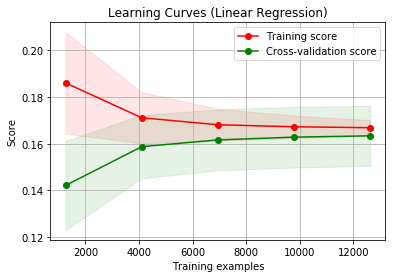

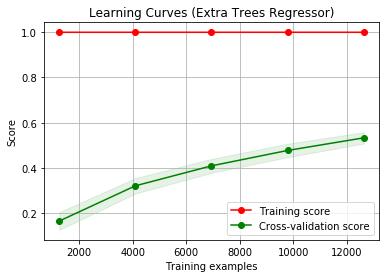

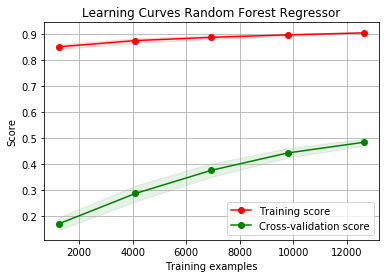

Wall time: 2min 25s


In [22]:
%%time
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


X, y = X_trn.values, y_trn.values


title = "Learning Curves (Linear Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = LinearRegression()
plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=4)

title = "Learning Curves (Extra Trees Regressor)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = ExtraTreesRegressor()
plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=4)

title = "Learning Curves Random Forest Regressor"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = RandomForestRegressor()
plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=4)

plt.show()

#### Regularization

In [33]:
def getResults(X_test,y_test,predictions):    
    print('R2 :{:.3f}'.format(ridgeReg.score(X_test,y_test)))
    print('MSE: {:.3f}'.format(mean_squared_error(y_test,predictions)))
    print('RMSE: {:.3f}'.format(np.sqrt(mean_squared_error(y_test,predictions))))
    print('MAE: {:.3f}'.format(mean_absolute_error(y_test,predictions)))
    print('MAPE:{:.3f}'.format(np.mean(np.abs((y_test - predictions) / y_test)) * 100))

In [34]:
from sklearn.linear_model import Ridge

## training the model

ridgeReg = Ridge(alpha=0.05, normalize=True)

ridgeReg.fit(X_trn,y_trn)

predictions = ridgeReg.predict(X_test)
getResults(X_test,y_test,predictions)

R2 :0.143
MSE: 9120.449
RMSE: 95.501
MAE: 53.669
MAPE:63.295


In [36]:
from sklearn.linear_model import Lasso

## training the model

LassoReg = Lasso(alpha=0.005, normalize=True)

LassoReg.fit(X_trn,y_trn)

predictions = LassoReg.predict(X_test)
getResults(X_test,y_test,predictions)

R2 :0.143
MSE: 9083.028
RMSE: 95.305
MAE: 53.772
MAPE:63.765


In [45]:
from sklearn.linear_model import ElasticNet

## training the model

ElasticNetReg = ElasticNet(alpha=0.00000001, normalize=True)

ElasticNetReg.fit(X_trn,y_trn)

predictions = ElasticNetReg.predict(X_test)
getResults(X_test,y_test,predictions)

R2 :0.143
MSE: 9016.113
RMSE: 94.953
MAE: 53.751
MAPE:63.529


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
